In [230]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from scipy.optimize import fmin_cg, minimize

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
import operator


#X1 transaction date	
# X2 house age	
# X3 distance to the nearest MRT station	
# X4 number of convenience stores	
# X5 latitude	
# X6 longitude	
# Y house price of unit area


In [231]:
# def costFunction(X, y, theta, lamb=0):
#     m = len(X)
#     h = X @ theta
#     J = (1/(2*m)) * (h - y).T @ (h - y)
#     theta[0] = 0
#     reg = (lamb/(2*m)) * np.sum(theta ** 2)
#     return np.asscalar(J)+reg

def grad(X,y,theta,lamb=0):
   # print(X,y,theta,lamb)
    h = X @ theta
    return (1/m)*(X.T * (h - y))

def gradientDescent(X,y,theta,alpha,num_iters, lamb=0):
    history = list()
    m = len(X)
    for i in range(num_iters):
        h = X @ theta
        errors = h - y
        delta = alpha * ((1/m) * (X.transpose() @ errors))
        theta = (theta - delta)+(lamb/m)*theta
        J = costFunction(X,y,theta)
        history.append(J)
    return theta, history

def normalizeFeatures(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return (X_norm, mu, sigma)

def solve(X, y):
    XTX=X.T @ X
    XTy=X.T @ y
    return np.linalg.solve(XTX,XTy)

def normalEquation(X, y):
    theta = np.linalg.pinv((X.T @ X))@(X.T@y)
    return theta

def polyFeatures (X, d):
    # X shouldnt have ones added as first column
    X_poly = np.zeros((len(X), d+1))
    for i in range(d+1):
        X_poly[:,i] = (X**i)
    return X_poly

def costFunction(X,y,theta, lamb=0):
    m = len(X)
    h = X @ theta
    J = (1/(2*m))*np.sum((h - y)**2)
    reg = (lamb/(2*m)) * np.sum(theta ** 2)
    return J+reg


In [232]:

df = pd.read_csv("real_estate_valuation.txt", header=None, sep=' ')
df.columns = ["Id","Transaction date", "Age", "distance to MRT", "number of stores", "lat", "lon", "price"]
df = df[["Age", "distance to MRT", "number of stores","price"]].copy()
data = df.values
print(df.head(), "\n\n", df.describe())

    Age  distance to MRT  number of stores  price
0  32.0         84.87882                10   37.9
1  19.5        306.59470                 9   42.2
2  13.3        561.98450                 5   47.3
3  13.3        561.98450                 5   54.8
4   5.0        390.56840                 5   43.1 

               Age  distance to MRT  number of stores       price
count  414.000000       414.000000        414.000000  414.000000
mean    17.712560      1083.885689          4.094203   37.980193
std     11.392485      1262.109595          2.945562   13.606488
min      0.000000        23.382840          0.000000    7.600000
25%      9.025000       289.324800          1.000000   27.700000
50%     16.100000       492.231300          4.000000   38.450000
75%     28.150000      1454.279000          6.000000   46.600000
max     43.800000      6488.021000         10.000000  117.500000


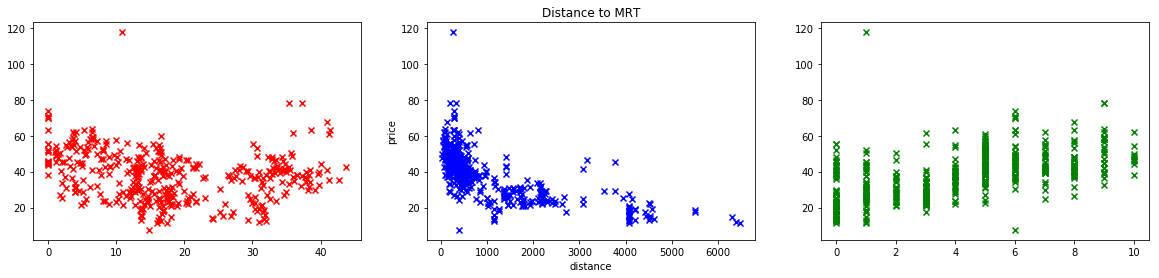

In [233]:
m = len(data)
# length of target datasets
cv_len = int(np.floor(0.2*m))
train_len = int(np.floor(0.6*m))

X = data[:,:-1]
# X = data[:,:-1]
y = data[:,-1:]
X = np.hstack((np.ones((m,1)), X))
n = X.shape[1]

X_train = X[:train_len+cv_len]
y_train = y[:train_len+cv_len]

# X_cv = X[train_len:train_len+cv_len]
# y_cv = y[train_len:train_len+cv_len]

X_test = X[train_len+cv_len:]
y_test = y[train_len+cv_len:]

fig, [ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax1.scatter(X[:,1], y, color="red", marker="x")
ax2.scatter(X[:,2:3], y, color="blue", marker="x")
ax2.set_title("Distance to MRT")
ax2.set_ylabel("price")
ax2.set_xlabel("distance")
ax3.scatter(X[:,3:4], y, color="green", marker="x")


Predicting price with distance to MRT
Cost with gd:  37.696252530923225
Mean squared error:  75.39250506184645
Variance score: 0.52


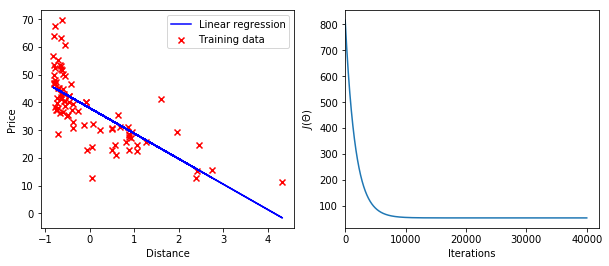

In [255]:
print("Predicting price with distance to MRT")

dist_train = X_train[:,(0,2)]
dist_test = X_test[:,(0,2)]
n = dist_train.shape[1]
m = dist_train.shape[0]
# sc_X=StandardScaler()
# dist_train=sc_X.fit_transform(dist_train[:,1].reshape(m,1))
dist_train, mu, sigma = normalizeFeatures(dist_train[:,1])
dist_train = dist_train.reshape((len(dist_train),1))
dist_train = np.hstack((np.ones((len(dist_train),1)), dist_train))
iters = 40000
theta_init = np.zeros((n,1))
theta, history = gradientDescent(dist_train,y_train, theta_init, 0.0003, iters)

# we normalized the training data so we must fo the same with test before making a prediction
dist_test, mu, sigma = normalizeFeatures(dist_test[:,1])
dist_test = dist_test.reshape((len(dist_test),1))
dist_test = np.hstack((np.ones((len(dist_test),1)), dist_test))
y_pred = dist_test@theta

print("Cost with gd: ", costFunction(dist_test, y_test, theta))
print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax1.scatter(dist_test[:,1], y_test, color="red", marker="x")
ax1.plot(dist_test[:,1], y_pred, color="blue")
ax1.legend(['Linear regression', 'Training data'])
ax1.set_xlabel("Distance")
ax1.set_ylabel("Price")

ax2.plot(np.arange(iters), np.array(history)[:, np.newaxis])
ax2.set_xlabel("Iterations")
ax2.set_ylabel("$J(\Theta)$")
ax2.set_xlim(left=0)
plt.show()


Cost with solve:  53.68815403667501
Mean squared error:  75.38786156123822
Variance score: 0.52


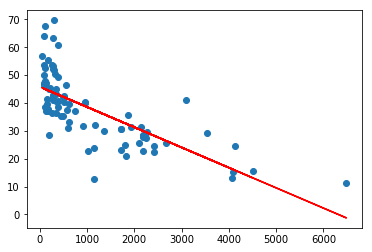

In [194]:

dist_train = X_train[:,(0,2)]
dist_test = X_test[:,(0,2)]
n = dist_train.shape[1]
theta = solve(dist_train, y_train)
print("Cost with solve: ", costFunction(dist_train, y_train, theta, 0))
y_pred = dist_test@theta
print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

plt.scatter(dist_test[:,1],y_test)
plt.plot(dist_test[:,1],y_pred, color="red")
plt.show()


using scikit linear model
Mean squared error: 75.39
Variance score: 0.52 



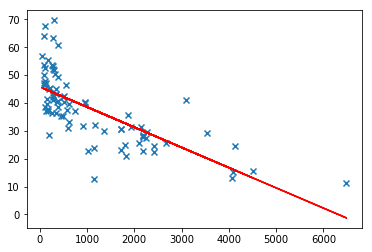

using scikit linear model with poly features
Mean squared error: 57.62
Variance score: 0.64 



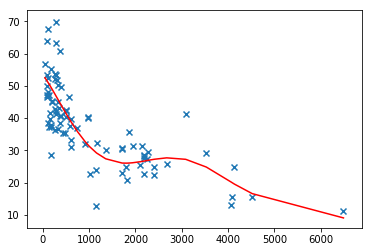

In [63]:
regr = linear_model.LinearRegression(normalize=True)
regr.fit(dist_train, y_train)
y_pred = regr.predict(dist_test)

# The coefficients
# The mean squared error
print("using scikit linear model")
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred), "\n")
fig, ax1 = plt.subplots()
ax1.scatter(dist_test[:,1],y_test, marker="x")
ax1.plot(dist_test[:,1],y_pred, color="red")
plt.show()

poly = PolynomialFeatures(6)
dist_poly_train = poly.fit_transform(dist_train[:,1:])
# dist_poly_train = np.hstack((np.ones((len(dist_poly_train), 1)), dist_poly_train))
dist_poly_test = poly.fit_transform(dist_test[:,1:])
# dist_poly_test = np.hstack((np.ones((len(dist_poly_test), 1)), dist_poly_test))
regr.fit(dist_poly_train, y_train)
y_pred = regr.predict(dist_poly_test)

print("using scikit linear model with poly features")
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred), "\n")

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(dist_test[:,1],y_pred), key=sort_axis)
[x, y] = zip(*sorted_zip)
plt.plot(x,y, color='red')
plt.scatter(dist_test[:,1],y_test, marker='x')
plt.show()

In [8]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=6)),
    ('model', LinearRegression())
    
]

pipeline = Pipeline(steps)

pipeline.fit(dist_train, y_train)
y_pred = pipeline.predict(dist_test)

print("using scikit linear model")
print("Error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Training Score: %.2f' % pipeline.score(dist_train, y_train))
print('Test Score: %.2f' % pipeline.score(dist_test, y_test), "\n")

steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(5)),
    ('model', Ridge(alpha=10, fit_intercept=True))
]

pipeline = Pipeline(steps)

pipeline.fit(dist_train, y_train)
y_pred = pipeline.predict(dist_test)

print("using scikit ridge model")
print("Error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Training Score: %.2f' % pipeline.score(dist_train, y_train))
print('Test Score: %.2f' % pipeline.score(dist_test, y_test), "\n")


steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(5)),
    ('model', Lasso(alpha=0.03, max_iter = 30000,fit_intercept=True))
]

pipeline = Pipeline(steps)

pipeline.fit(dist_train, y_train)
y_pred = pipeline.predict(dist_test)

print("using scikit lasso model")
print("Error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Training Score: %.2f' % pipeline.score(dist_train, y_train))
print('Test Score: %.2f' % pipeline.score(dist_test, y_test), "\n")

using scikit linear model
Error: 7.59
Training Score: 0.56
Test Score: 0.64 

using scikit ridge model
Error: 7.75
Training Score: 0.55
Test Score: 0.62 

using scikit lasso model
Error: 7.77
Training Score: 0.56
Test Score: 0.62 



Mean squared error: 69.84
Variance score: 0.56 



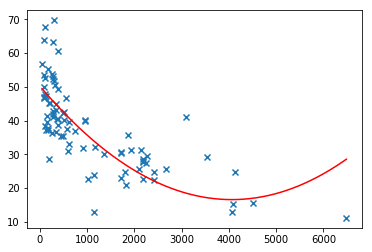

In [43]:

deg = 2
dist_poly_train = polyFeatures(dist_train[:,1], deg)
dist_poly_test = polyFeatures(dist_test[:,1],deg)
theta_init = np.zeros((dist_poly_train.shape[1],deg))
theta = normalEquation(dist_poly_train, y_train)
y_pred = dist_poly_test@theta
#dist_poly = np.hstack((np.ones(len(dist_poly)), dist_poly))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred), "\n")

x = np.arange(np.min(dist_test[:,1]), np.max(dist_test[:,1]), 0.5)
# x = x.reshape(len(x),1)
xpoly = polyFeatures(x, deg)
# xpoly = np.hstack((np.ones((len(xpoly), 1)), xpoly))
plt.scatter(dist_test[:,1], y_test, marker='x')
plt.plot(x, xpoly @ theta, color='red')
plt.show()

#### Predicting with all features

In [27]:
theta = solve(X_train, y_train)
print("Cost with solve: ", costFunction(X_train, y_train, theta, 0))
pred = X_test@theta
print("Mean squared error: ", mean_squared_error(y_test, pred))
print('Variance score: %.2f' % r2_score(y_test, pred))

Cost with solve:  45.02829262202533
Mean squared error:  64.10367916075953
Variance score: 0.59


In [38]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
#print('Coefficients: %.2f' % regr.coef_)
# The mean squared error
print("using scikit linear model")
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred), "\n")


steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(6)),
    ('model', Ridge(alpha=0.02, fit_intercept=True))
]

pipeline = Pipeline(steps)

pipeline.fit(dist_train, y_train)
y_pred = pipeline.predict(dist_test)

print("using scikit ridge model")
print("Error: %.2f"
      % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Training Score: %.2f' % pipeline.score(dist_train, y_train))
print('Test Score: %.2f' % pipeline.score(dist_test, y_test), "\n")

using scikit linear model
Mean squared error: 64.10
Variance score: 0.59 

using scikit ridge model
Error: 7.59
Training Score: 0.56
Test Score: 0.64 



In [224]:
n=X_train.shape[1]
theta_init = np.ones((n,1))
theta, history = gradientDescent(X_train,y_train, theta_init, 0.0000003, 1400)
y_pred = X_test@theta
print("Cost with gd: ", costFunction(X_train, y_train, theta))
print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))



Cost with gd:  278.2604239772256
Mean squared error:  541.2576107177019
Variance score: -2.43


In [225]:
theta_init = np.zeros((n,1))
theta = normalEquation(X_train, y_train)
y_pred = X_test@theta
print("Cost with gd: ", costFunction(X_train, y_train, theta, 0))
print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Cost with gd:  45.02829262202533
Mean squared error:  64.10367916076191
Variance score: 0.59


#### Same with feature normalization

In [226]:
X, mu, sigma = normalizeFeatures(data[:,:-1])
y = data[:,-1:]
X = np.hstack((np.ones((m,1)), X))
n = X.shape[1]

X_train = X[:train_len]
y_train = y[:train_len]

X_cv = X[train_len:train_len+cv_len]
y_cv = y[train_len:train_len+cv_len]

X_test = X[train_len+cv_len:]
y_test = y[train_len+cv_len:]


In [227]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
#print('Coefficients: %.2f' % regr.coef_)
# The mean squared error
print("using scikit linear model")
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

using scikit linear model
Mean squared error: 64.75
Variance score: 0.59


In [228]:
print("Cost function and gradient with theta as row vector")

def costFunction(theta,X,y, lamb=0):
    m = len(X)
    h = X @ theta.T
    J = (1/(2*m))*np.sum((h - y)**2)
    theta[0] = 0
    reg = (lamb/(2*m)) * np.sum(theta**2)
    return J + reg


def grad(theta,X,y, lamb=0):
   # print(X,y,theta,lamb)
    m = len(X)
    h = (X @ theta.T).reshape((m,1))
    theta[0] = 0
    return ((1/m)*(X.T @ (h - y))).T[0] + (lamb/m) * theta


Cost function and gradient with theta as row vector


In [230]:
m = len(data)
# length of target datasets
cv_len = int(np.floor(0.2*m))
train_len = int(np.floor(0.6*m))

X = data[:,2:3]
y = data[:,-1:]

#X, mu, sigma = normalizeFeatures(data[:,2:3])

X = np.hstack((np.ones((m,1)), X))
n = X.shape[1]

X_train = X[:train_len]
y_train = y[:train_len]

X_cv = X[train_len:train_len+cv_len]
y_cv = y[train_len:train_len+cv_len]

X_test = X[train_len+cv_len:]
y_test = y[train_len+cv_len:]


init_theta = np.zeros(n)
theta = fmin_cg(costFunction, init_theta, epsilon=0.0001, maxiter=1500, fprime=grad, args=(X_train, y_train, 100))

         Current function value: 79611.464830
         Iterations: 2
         Function evaluations: 89
         Gradient evaluations: 78
